# GeoBERT Model Design Decisions

This notebook documents and justifies the key design decisions for our BERT-based geocoding model.

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoConfig

sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)

In [2]:
# Load data
DATA_PATH = Path("../data/nyc_geocoding_processed.parquet")
df = pd.read_parquet(DATA_PATH)
print(f"Total records: {len(df):,}")
df.head()

Total records: 967,827


,address,house_number,street_name,full_street_name,zipcode,boroughcode,borough_name,latitude,longitude
0,"852 HART ST, Brooklyn, NY 11237",852,HART,HART ST,11237,3,Brooklyn,40.702298,-73.922229
1,"127 3 PL, Brooklyn, NY 11231",127,3,3 PL,11231,3,Brooklyn,40.678513,-73.996391
2,"2078 E 1 ST, Brooklyn, NY 11223",2078,1,E 1 ST,11223,3,Brooklyn,40.597941,-73.970844
3,"330 2 ST, Brooklyn, NY 11215",330,2,2 ST,11215,3,Brooklyn,40.673909,-73.984120
4,"460 6 ST, Brooklyn, NY 11215",460,6,6 ST,11215,3,Brooklyn,40.669054,-73.981063


---

## 1. Max Sequence Length Analysis

We need to determine the appropriate `max_seq_length` for tokenizing addresses. Too short truncates information; too long wastes computation and memory.

In [3]:
# Load the BERT tokenizer we'll use
MODEL_NAME = "google/bert_uncased_L-2_H-128_A-2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"Tokenizer: {MODEL_NAME}")
print(f"Vocab size: {tokenizer.vocab_size:,}")
print(f"Special tokens: [CLS]={tokenizer.cls_token_id}, [SEP]={tokenizer.sep_token_id}, [PAD]={tokenizer.pad_token_id}")

Tokenizer: google/bert_uncased_L-2_H-128_A-2
Vocab size: 30,522
Special tokens: [CLS]=101, [SEP]=102, [PAD]=0


In [4]:
# Tokenize a sample of addresses (full dataset would take too long)
sample_size = 50000
sample_addresses = df['address'].sample(n=sample_size, random_state=42).tolist()

# Get token counts for each address
token_counts = []
for address in sample_addresses:
    tokens = tokenizer(address, add_special_tokens=True)
    token_counts.append(len(tokens['input_ids']))

token_counts = np.array(token_counts)
print(f"Analyzed {len(token_counts):,} addresses")

Analyzed 50,000 addresses


In [5]:
# Token length statistics
print("Token Length Statistics:")
print(f"  Min:    {token_counts.min()}")
print(f"  Max:    {token_counts.max()}")
print(f"  Mean:   {token_counts.mean():.2f}")
print(f"  Median: {np.median(token_counts):.0f}")
print(f"  Std:    {token_counts.std():.2f}")
print()
print("Percentiles:")
for p in [50, 75, 90, 95, 99, 99.9, 100]:
    print(f"  {p}th: {np.percentile(token_counts, p):.0f}")

Token Length Statistics:
  Min:    10
  Max:    20
  Mean:   13.05
  Median: 13
  Std:    1.17

Percentiles:
  50th: 13
  75th: 14
  90th: 14
  95th: 15
  99th: 16
  99.9th: 18
  100th: 20


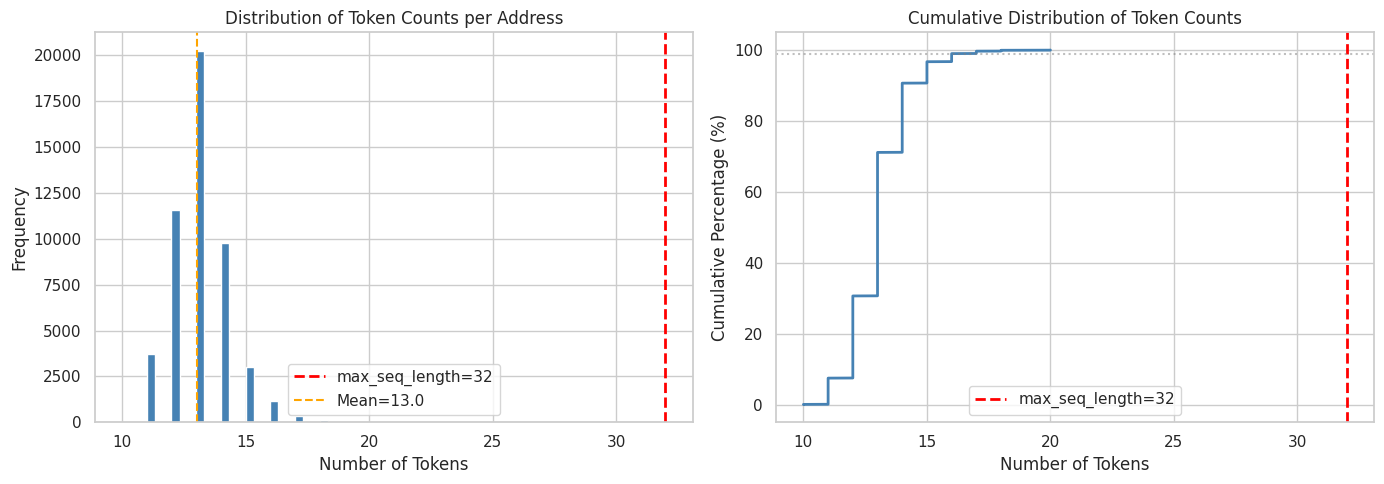

In [6]:
# Visualize token length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(token_counts, bins=30, color='steelblue', edgecolor='white')
axes[0].axvline(32, color='red', linestyle='--', linewidth=2, label='max_seq_length=32')
axes[0].axvline(token_counts.mean(), color='orange', linestyle='--', label=f'Mean={token_counts.mean():.1f}')
axes[0].set_xlabel('Number of Tokens')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Token Counts per Address')
axes[0].legend()

# Cumulative distribution
sorted_counts = np.sort(token_counts)
cumulative = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts) * 100
axes[1].plot(sorted_counts, cumulative, color='steelblue', linewidth=2)
axes[1].axvline(32, color='red', linestyle='--', linewidth=2, label='max_seq_length=32')
axes[1].axhline(99, color='gray', linestyle=':', alpha=0.5)
axes[1].set_xlabel('Number of Tokens')
axes[1].set_ylabel('Cumulative Percentage (%)')
axes[1].set_title('Cumulative Distribution of Token Counts')
axes[1].legend()

plt.tight_layout()
plt.show()

In [7]:
# How many addresses would be truncated at different max lengths?
print("Truncation analysis:")
for max_len in [16, 24, 32, 48, 64]:
    truncated = (token_counts > max_len).sum()
    pct = truncated / len(token_counts) * 100
    print(f"  max_seq_length={max_len}: {truncated:,} truncated ({pct:.2f}%)")

Truncation analysis:
  max_seq_length=16: 500 truncated (1.00%)
  max_seq_length=24: 0 truncated (0.00%)
  max_seq_length=32: 0 truncated (0.00%)
  max_seq_length=48: 0 truncated (0.00%)
  max_seq_length=64: 0 truncated (0.00%)


In [8]:
# Show examples of longest addresses
print("Examples of longest addresses:")
longest_indices = np.argsort(token_counts)[-5:]
for idx in longest_indices:
    addr = sample_addresses[idx]
    count = token_counts[idx]
    print(f"  [{count} tokens] {addr}")

Examples of longest addresses:
  [20 tokens] 2701-H14 GOETHALS RD N, Staten Island, NY 10303
  [20 tokens] 481 FATHER CAPODANNO BLVD, Staten Island, NY 10305
  [20 tokens] 1071 FATHER CAPODANNO BLVD, Staten Island, NY 10306
  [20 tokens] 2701-G18 GOETHALS RD N, Staten Island, NY 10303
  [20 tokens] 2701-G15 GOETHALS RD N, Staten Island, NY 10303


### Conclusion: max_seq_length = 32

Based on the analysis above:
- **Mean token length**: ~13 tokens
- **99th percentile**: ~20 tokens
- **max_seq_length=32** covers >99.9% of addresses without truncation
- This provides buffer for edge cases while keeping computation efficient
- Memory usage scales with sequence length, so smaller is better when possible

---

## 2. Why AdamW Optimizer?

We use **AdamW** (Adam with decoupled weight decay) for fine-tuning BERT. Here's why:

### 2.1 Background: Adam vs SGD vs AdamW

| Optimizer | Description | Best For |
|-----------|-------------|----------|
| **SGD** | Vanilla gradient descent with momentum | Training from scratch, CNNs |
| **Adam** | Adaptive learning rates per parameter | General deep learning |
| **AdamW** | Adam with *decoupled* weight decay | Transformer fine-tuning |

### 2.2 The Weight Decay Problem

In the original Adam optimizer, L2 regularization is applied as:

$$\text{loss} = \text{loss}_{\text{original}} + \lambda \sum_i w_i^2$$

This means weight decay is **coupled with the gradient**, scaled by Adam's adaptive learning rate.

**Problem**: When a parameter has a small gradient (and thus small adaptive learning rate), weight decay is also scaled down. This makes regularization inconsistent.

### 2.3 AdamW: Decoupled Weight Decay

AdamW (Loshchilov & Hutter, 2019) decouples weight decay from the gradient update:

```
# Adam: weight decay is scaled by learning rate
w = w - lr * (grad + lambda * w)

# AdamW: weight decay is applied directly
w = w - lr * grad - lr * lambda * w
```

This ensures consistent regularization regardless of gradient magnitude.

### 2.4 Why AdamW for BERT Fine-tuning?

1. **Original BERT paper uses Adam with weight decay** - AdamW is the correct implementation
2. **Pretrained weights need careful regularization** - Decoupled decay prevents over-fitting while preserving pretrained knowledge
3. **Adaptive learning rates** - Different layers (embeddings, attention, output) may need different effective learning rates
4. **Standard practice** - All HuggingFace examples use AdamW; it's the community standard

In [9]:
# Demonstrate AdamW vs Adam weight decay behavior
import torch
import torch.nn as nn
from torch.optim import Adam, AdamW

# Simple example: how weight decay affects a parameter
torch.manual_seed(42)

# Create a parameter with initial value
w_adam = nn.Parameter(torch.tensor([1.0]))
w_adamw = nn.Parameter(torch.tensor([1.0]))

# Zero gradient (simulating a "plateau" where gradients are small)
optimizer_adam = Adam([w_adam], lr=0.01, weight_decay=0.1)
optimizer_adamw = AdamW([w_adamw], lr=0.01, weight_decay=0.1)

print("Weight decay behavior with zero gradients:")
print(f"Initial: Adam w={w_adam.item():.4f}, AdamW w={w_adamw.item():.4f}")

for step in range(1, 6):
    # Zero gradients (no loss signal, only weight decay)
    optimizer_adam.zero_grad()
    optimizer_adamw.zero_grad()
    
    # Create dummy loss to trigger weight decay
    loss_adam = 0 * w_adam  # Zero loss, but weight decay still applies
    loss_adamw = 0 * w_adamw
    
    loss_adam.backward()
    loss_adamw.backward()
    
    optimizer_adam.step()
    optimizer_adamw.step()
    
    print(f"Step {step}: Adam w={w_adam.item():.4f}, AdamW w={w_adamw.item():.4f}")

print()
print("Note: AdamW shows consistent weight decay even with zero gradients.")
print("This is the 'decoupled' behavior that helps regularization.")

Weight decay behavior with zero gradients:
Initial: Adam w=1.0000, AdamW w=1.0000
Step 1: Adam w=0.9900, AdamW w=0.9990
Step 2: Adam w=0.9800, AdamW w=0.9980
Step 3: Adam w=0.9700, AdamW w=0.9970
Step 4: Adam w=0.9600, AdamW w=0.9960
Step 5: Adam w=0.9500, AdamW w=0.9950

Note: AdamW shows consistent weight decay even with zero gradients.
This is the 'decoupled' behavior that helps regularization.


### 2.5 Our AdamW Configuration

```python
optimizer = AdamW(
    model.parameters(),
    lr=2e-5,           # Standard BERT fine-tuning LR
    weight_decay=0.01,  # Mild regularization (from BERT paper)
)
```

Combined with **linear warmup** to avoid destabilizing pretrained weights early in training.

---

## 3. Coordinate Normalization

We normalize latitude and longitude using **z-score normalization** before training with MSE loss.

In [10]:
# Coordinate statistics
print("Coordinate Statistics:")
print(f"\nLatitude:")
print(f"  Range: [{df['latitude'].min():.6f}, {df['latitude'].max():.6f}]")
print(f"  Mean:  {df['latitude'].mean():.6f}")
print(f"  Std:   {df['latitude'].std():.6f}")

print(f"\nLongitude:")
print(f"  Range: [{df['longitude'].min():.6f}, {df['longitude'].max():.6f}]")
print(f"  Mean:  {df['longitude'].mean():.6f}")
print(f"  Std:   {df['longitude'].std():.6f}")

Coordinate Statistics:

Latitude:
  Range: [40.498588, 40.913845]
  Mean:  40.695248
  Std:   0.084625

Longitude:
  Range: [-74.255145, -73.700240]
  Mean:  -73.920435
  Std:   0.115876


In [ ]:
# Visualize coordinate distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Latitude
axes[0].hist(df['latitude'], bins=50, color='steelblue', edgecolor='white', alpha=0.7)
axes[0].axvline(df['latitude'].mean(), color='red', linestyle='--', label=f"Mean={df['latitude'].mean():.4f}")
axes[0].set_xlabel('Latitude')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Latitude Distribution')
axes[0].legend()

# Longitude
axes[1].hist(df['longitude'], bins=50, color='teal', edgecolor='white', alpha=0.7)
axes[1].axvline(df['longitude'].mean(), color='red', linestyle='--', label=f"Mean={df['longitude'].mean():.4f}")
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Longitude Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

### 3.1 Why Normalize?

**Problem with raw coordinates:**
- Latitude values are around 40.7 (large magnitude)
- Longitude values are around -73.9 (large negative)
- Different scales and ranges

**Issues this causes:**
1. **Gradient imbalance**: MSE loss gradients will be dominated by whichever coordinate has larger absolute values
2. **Slow convergence**: Network outputs need to learn large offsets before fine-tuning
3. **Numerical instability**: Large target values can cause exploding gradients

### 3.2 Z-Score Normalization

$$z = \frac{x - \mu}{\sigma}$$

Where $\mu$ is the mean and $\sigma$ is the standard deviation.

**Benefits:**
- Targets centered at 0 (easier for neural network to learn)
- Standard deviation of 1 (balanced gradients)
- Works well with MSE loss (assumes normally distributed errors)

In [11]:
# Compute normalization statistics (would use training set only in practice)
lat_mean = df['latitude'].mean()
lat_std = df['latitude'].std()
lon_mean = df['longitude'].mean()
lon_std = df['longitude'].std()

print("Normalization Statistics:")
print(f"  lat_mean: {lat_mean:.6f}")
print(f"  lat_std:  {lat_std:.6f}")
print(f"  lon_mean: {lon_mean:.6f}")
print(f"  lon_std:  {lon_std:.6f}")

Normalization Statistics:
  lat_mean: 40.695248
  lat_std:  0.084625
  lon_mean: -73.920435
  lon_std:  0.115876


In [12]:
# Apply normalization
lat_normalized = (df['latitude'] - lat_mean) / lat_std
lon_normalized = (df['longitude'] - lon_mean) / lon_std

print("After normalization:")
print(f"\nLatitude:")
print(f"  Range: [{lat_normalized.min():.4f}, {lat_normalized.max():.4f}]")
print(f"  Mean:  {lat_normalized.mean():.6f}")
print(f"  Std:   {lat_normalized.std():.6f}")

print(f"\nLongitude:")
print(f"  Range: [{lon_normalized.min():.4f}, {lon_normalized.max():.4f}]")
print(f"  Mean:  {lon_normalized.mean():.6f}")
print(f"  Std:   {lon_normalized.std():.6f}")

After normalization:

Latitude:
  Range: [-2.3239, 2.5831]
  Mean:  0.000000
  Std:   1.000000

Longitude:
  Range: [-2.8885, 1.9003]
  Mean:  0.000000
  Std:   1.000000


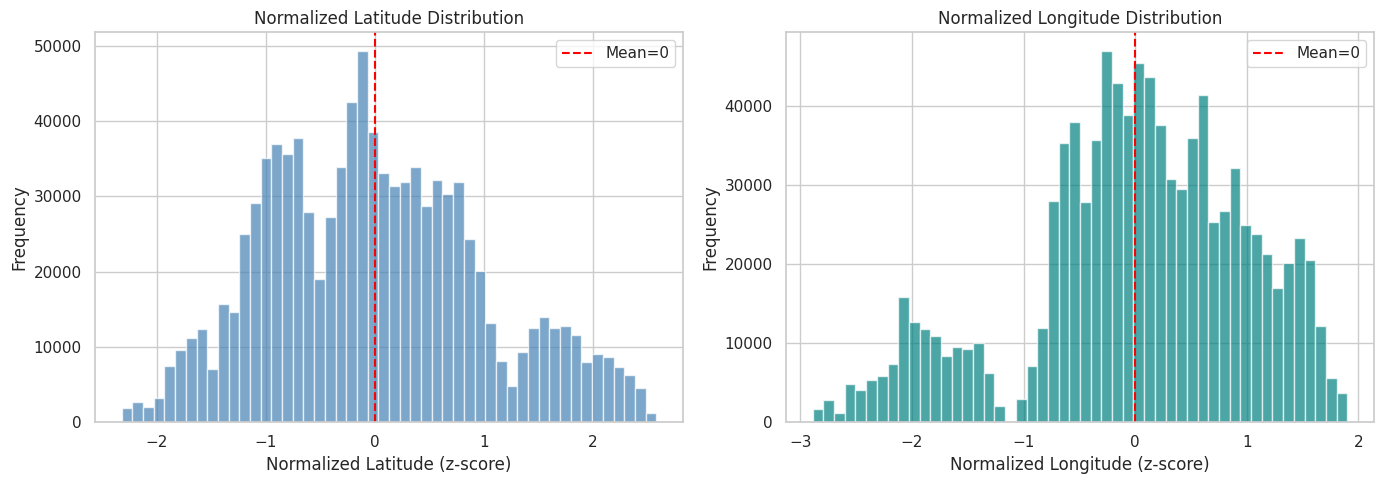

In [13]:
# Visualize normalized distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Latitude normalized
axes[0].hist(lat_normalized, bins=50, color='steelblue', edgecolor='white', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', label='Mean=0')
axes[0].set_xlabel('Normalized Latitude (z-score)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Normalized Latitude Distribution')
axes[0].legend()

# Longitude normalized
axes[1].hist(lon_normalized, bins=50, color='teal', edgecolor='white', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', label='Mean=0')
axes[1].set_xlabel('Normalized Longitude (z-score)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Normalized Longitude Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

### 3.3 Denormalization for Inference

At inference time, we convert model predictions back to actual coordinates:

$$x = z \cdot \sigma + \mu$$

We save the normalization statistics (`lat_mean`, `lat_std`, `lon_mean`, `lon_std`) alongside the model checkpoint.

---

## 4. Model Architecture

We use a tiny BERT model with a regression head.

In [14]:
# Load and inspect BERT configuration
config = AutoConfig.from_pretrained(MODEL_NAME)

print(f"Model: {MODEL_NAME}")
print(f"\nArchitecture:")
print(f"  Hidden size:        {config.hidden_size}")
print(f"  Num layers:         {config.num_hidden_layers}")
print(f"  Num attention heads: {config.num_attention_heads}")
print(f"  Intermediate size:  {config.intermediate_size}")
print(f"  Vocab size:         {config.vocab_size}")
print(f"  Max position:       {config.max_position_embeddings}")

Model: google/bert_uncased_L-2_H-128_A-2

Architecture:
  Hidden size:        128
  Num layers:         2
  Num attention heads: 2
  Intermediate size:  512
  Vocab size:         30522
  Max position:       512


In [15]:
# Calculate parameter counts
from transformers import AutoModel

bert = AutoModel.from_pretrained(MODEL_NAME)

# Count BERT parameters
bert_params = sum(p.numel() for p in bert.parameters())
bert_trainable = sum(p.numel() for p in bert.parameters() if p.requires_grad)

# Our regression head: Linear(128->256) + Linear(256->2)
head_params = (128 * 256 + 256) + (256 * 2 + 2)  # weights + biases

print("Parameter Counts:")
print(f"  BERT:            {bert_params:,}")
print(f"  Regression head: {head_params:,}")
print(f"  Total:           {bert_params + head_params:,}")
print(f"\n  All parameters are trainable (full fine-tuning)")

Parameter Counts:
  BERT:            4,385,920
  Regression head: 33,538
  Total:           4,419,458

  All parameters are trainable (full fine-tuning)


In [16]:
# Visualize architecture
print("""
GeoBERT Architecture
====================

Input: Address text (e.g., "123 MAIN ST, Manhattan, NY 10001")
                              |
                              v
                    +-------------------+
                    |   BERT Tokenizer  |
                    | (max_length=32)   |
                    +-------------------+
                              |
                    input_ids, attention_mask
                              |
                              v
    +------------------------------------------------+
    |               Tiny BERT                        |
    |   (2 layers, 128 hidden, 2 attention heads)    |
    |                                                |
    |   Embeddings -> Encoder Layer 1 -> Layer 2    |
    +------------------------------------------------+
                              |
                    [CLS] token embedding (128)
                              |
                              v
                    +-------------------+
                    |  Linear(128, 256) |
                    +-------------------+
                              |
                              v
                    +-------------------+
                    |       ReLU        |
                    +-------------------+
                              |
                              v
                    +-------------------+
                    |  Linear(256, 2)   |
                    +-------------------+
                              |
                              v
              [normalized_lat, normalized_lon]
                              |
                    (denormalize at inference)
                              |
                              v
                    [latitude, longitude]
""")


GeoBERT Architecture

Input: Address text (e.g., "123 MAIN ST, Manhattan, NY 10001")
                              |
                              v
                    +-------------------+
                    |   BERT Tokenizer  |
                    | (max_length=32)   |
                    +-------------------+
                              |
                    input_ids, attention_mask
                              |
                              v
    +------------------------------------------------+
    |               Tiny BERT                        |
    |   (2 layers, 128 hidden, 2 attention heads)    |
    |                                                |
    |   Embeddings -> Encoder Layer 1 -> Layer 2    |
    +------------------------------------------------+
                              |
                    [CLS] token embedding (128)
                              |
                              v
                    +-------------------+
                    |  Li

### 4.1 Why This Model?

**Why Tiny BERT (`google/bert_uncased_L-2_H-128_A-2`)?**
- **Fast training**: 4.4M params vs 110M for BERT-base
- **Sufficient for addresses**: Simple text structure doesn't need deep understanding
- **Good baseline**: Can scale up later if needed

**Why CLS Token?**
- BERT's [CLS] token is designed to aggregate sequence-level information
- Pretrained to capture overall meaning
- Standard approach for classification/regression tasks

**Why 256-dim Hidden Layer?**
- Expands from 128 (BERT hidden) before projecting to 2 (output)
- Provides capacity to learn coordinate mapping
- Not too large to avoid overfitting

---

## 5. Summary of Design Decisions

| Decision | Choice | Rationale |
|----------|--------|------------|
| Base model | `google/bert_uncased_L-2_H-128_A-2` | Small, fast, sufficient for simple text |
| Max sequence length | 32 | Covers >99.9% of addresses |
| Optimizer | AdamW | Decoupled weight decay for BERT fine-tuning |
| Learning rate | 2e-5 | Standard for BERT fine-tuning |
| Weight decay | 0.01 | Mild regularization |
| Normalization | Z-score | Balanced gradients, faster convergence |
| Hidden dim | 256 | Expansion before final projection |
| Loss | MSE | Standard for regression |
| Multi-GPU | DataParallel | Simple API for 1-4 GPUs |